In [1]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
import plotly.graph_objects as go

In [2]:
#encoding = "ISO-8859-1" as there is error using utf-8 encoding
df = pd.read_csv('data.csv', encoding = "ISO-8859-1",parse_dates = ['InvoiceDate'])

In [3]:
#InvoiceDate is parsed as dates correctly
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [4]:
#convert to date only no HH:MM
df['InvoiceDate'] = df['InvoiceDate'].dt.date

In [5]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom


In [6]:
df.Country.value_counts()[:5]

United Kingdom    495478
Germany             9495
France              8557
EIRE                8196
Spain               2533
Name: Country, dtype: int64

In [7]:
#we will use UK for TS analysis
df=df[df['Country']=='United Kingdom'].reset_index(drop=True)
df.Country.value_counts()[:5]

United Kingdom    495478
Name: Country, dtype: int64

In [8]:
#from Dec-2010 till Dec-2011 (around 1 year)
# we can run SARIMA, Holt Winter's and fbProphet(new library on the block)
min(df.InvoiceDate),max(df.InvoiceDate)

(datetime.date(2010, 12, 1), datetime.date(2011, 12, 9))

In [9]:
# 495478 rows vs 8 columns
df.shape

(495478, 8)

In [10]:
#there are multiple items per transaction which is normal
len(df['InvoiceNo'].unique())

23494

In [11]:
# calculate revenue
df['Revenue']=df['Quantity']*df['UnitPrice']

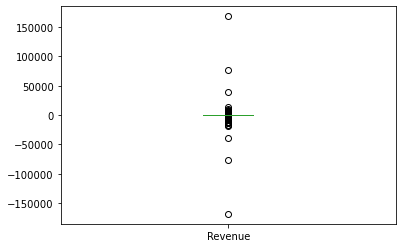

In [12]:
df['Revenue'].plot.box();

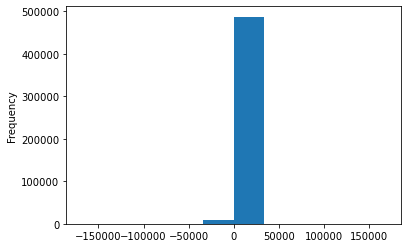

In [13]:
df['Revenue'].plot(kind='hist');

# fbProphet modelling

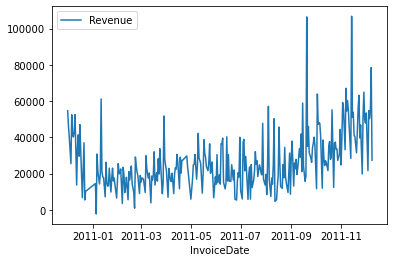

In [14]:
#visualizing of the Time Series below running the model
#it's addictive untill september and multiplicative after september
df.groupby(['InvoiceDate'])[['Revenue']].sum().plot();

In [18]:
chart.head()

,Revenue
InvoiceDate,
2010-12-01,54615.15
2010-12-02,46053.93
2010-12-03,39985.44
2010-12-05,25462.20
2010-12-06,52402.84


In [21]:
chart.index

Index([2010-12-01, 2010-12-02, 2010-12-03, 2010-12-05, 2010-12-06, 2010-12-07,
       2010-12-08, 2010-12-09, 2010-12-10, 2010-12-12,
       ...
       2011-11-29, 2011-11-30, 2011-12-01, 2011-12-02, 2011-12-04, 2011-12-05,
       2011-12-06, 2011-12-07, 2011-12-08, 2011-12-09],
      dtype='object', name='InvoiceDate', length=305)

In [26]:
chart.head()

,Revenue
InvoiceDate,
2010-12-01,54615.15
2010-12-02,46053.93
2010-12-03,39985.44
2010-12-05,25462.20
2010-12-06,52402.84


In [25]:
import plotly.graph_objects as go
chart = df.groupby(['InvoiceDate'])[['Revenue']].sum()

fig = go.Figure()
fig.add_trace(go.Scatter(x=chart.index, y=chart['Revenue'], name="stock_open"))
fig.layout.update(title_text='UK Revenue for year 2011 ',xaxis_rangeslider_visible=True)
fig.show()

In [15]:
#shape the df w.r.t requirement by fbProphet
df_prophet = df.groupby(['InvoiceDate'],as_index=False)[['Revenue']].sum()
df_prophet.head()

,InvoiceDate,Revenue
0,2010-12-01,54615.15
1,2010-12-02,46053.93
2,2010-12-03,39985.44
3,2010-12-05,25462.20
4,2010-12-06,52402.84


In [143]:
#remove negative value
#fbprophet works with 'None'
df_prophet.iloc[21,1]=None

In [144]:
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

def val_prophet(df,mode,train,cutoff,predict,changepoint):
    m = Prophet(seasonality_mode=mode,changepoint_prior_scale=changepoint)
    #m.add_country_holidays(country_name='UK')
    m.fit(df)
    future = m.make_future_dataframe(periods=3,freq='M')
    forecast = m.predict(future)
    df_cv = cross_validation(m, initial=train, period=cutoff, horizon = predict) 
    df_p = performance_metrics(df_cv)
    #print(df_p.head(15))
    #print(df_p.mape)
    fig = m.plot(forecast)
    fig2 = m.plot_components(forecast)
    #print('forecast')
    #print(forecast.tail(6))
    return df_cv,df_p,forecast

In [145]:
df_prophet.columns = ['ds','y']

### Baseline - no processing

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2011-09-10 00:00:00 and 2011-09-10 00:00:00


Average MAPE of first 12 days : 0.323


,horizon,mse,rmse,mae,mape,mdape,coverage
0,8 days,2.519455e+08,15872.792110,12037.170147,0.324550,0.281510,0.571429
1,9 days,1.814930e+08,13471.934229,9342.142891,0.256868,0.231605,0.714286
2,10 days,1.070525e+09,32718.872638,19691.847529,0.330079,0.281510,0.571429
3,11 days,1.061404e+09,32579.192529,19353.647443,0.330051,0.281510,0.571429
4,12 days,1.107326e+09,33276.505821,21688.984483,0.374812,0.350552,0.428571
5,13 days,9.855209e+08,31393.006513,18761.434619,0.347317,0.334818,0.571429


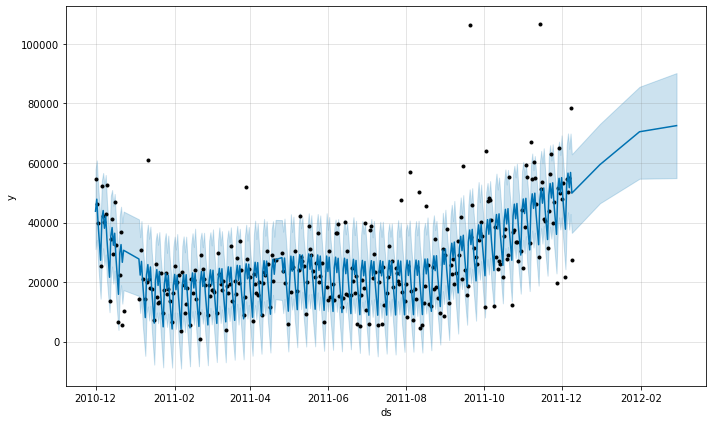

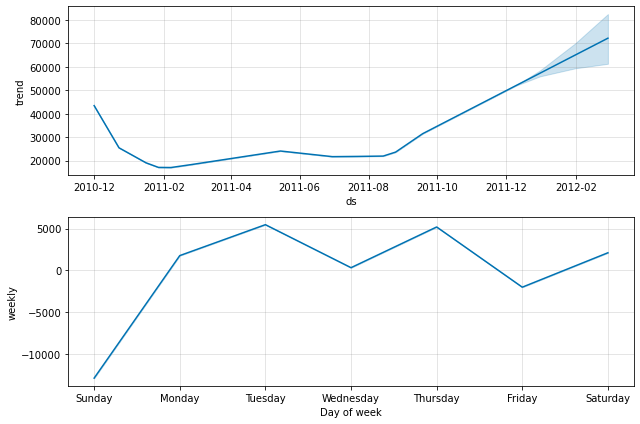

In [146]:
df_cv,df_p,forecast = val_prophet(df_prophet,'additive','270 days' ,'30 days','90 days',1)
print(f"Average MAPE of first 12 days : {df_p['mape'][:5].mean().round(3)}")
df_p.head(6)


# Remove outliers , 2 std deviation 

In [147]:
#function to remove outliers
def outliers_to_na(ts, devs):
    median= ts['y'].median()
    #print(median)
    std = np.std(ts['y'])
    #print(std)
    for x in range(len(ts)):
        val = ts['y'][x]
        #print(ts['y'][x])
        if (val < median - devs * std or val > median + devs * std):
            ts['y'][x] = None 
    return ts

In [148]:
# remove outliers based on 2 std dev
df_prophet_outliers = df_prophet.copy(deep=True )
outliers_to_na(df_prophet_outliers , 2)

C:\Users\andre\AppData\Local\Continuum\anaconda3\envs\fbprophet\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,ds,y
0,2010-12-01,NaN
1,2010-12-02,46053.93
2,2010-12-03,39985.44
3,2010-12-05,25462.20
4,2010-12-06,52402.84
...,...,...
300,2011-12-05,NaN
301,2011-12-06,50307.31
302,2011-12-07,NaN
303,2011-12-08,NaN


In [149]:
df_prophet_outliers.isna().sum()

ds     0
y     20
dtype: int64

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2011-09-10 00:00:00 and 2011-09-10 00:00:00


Average MAPE of first 12 days : 0.244


,horizon,mse,rmse,mae,mape,mdape,coverage
0,8 days,1.293969e+08,11375.274254,8641.433447,0.279908,0.233287,0.666667
1,9 days,5.156021e+07,7180.543902,5648.641077,0.206964,0.216456,0.833333
2,11 days,6.938325e+07,8329.660861,6613.766491,0.228197,0.231481,0.666667
3,12 days,8.606199e+07,9276.960033,7116.902953,0.233790,0.231481,0.666667
4,13 days,1.023552e+08,10117.076064,8487.756097,0.272453,0.283612,0.666667
5,15 days,1.476623e+08,12151.639691,10817.289179,0.350994,0.332285,0.500000


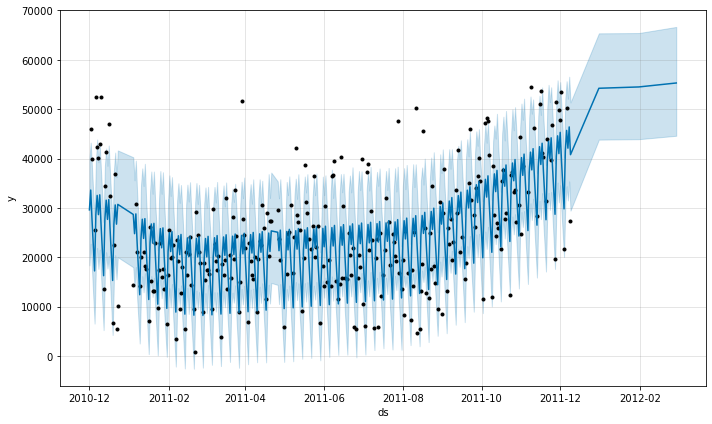

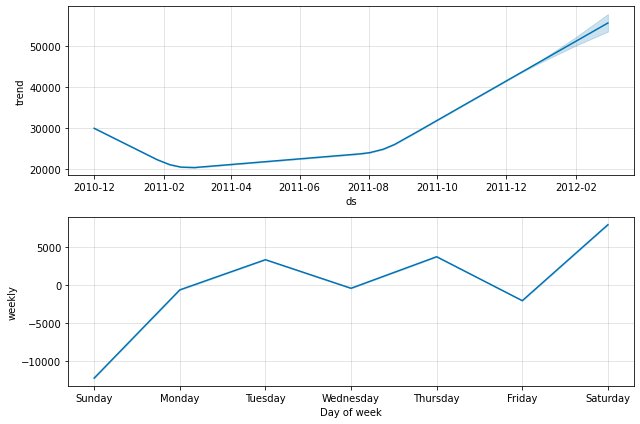

In [150]:
df_cv,df_p,forecast = val_prophet(df_prophet_outliers,'additive','270 days' ,'30 days','90 days',0.11)
print(f"Average MAPE of first 12 days : {df_p['mape'][:5].mean().round(3)}")
df_p.head(6)

# log transform the revenue 
the noise is positively skewed; the model is overestimating on lower values but underestimating on higher values.<p>
not much magic occured when it's logged

In [151]:
df_prophet_logp = df_prophet_outliers.copy(deep=True )
df_prophet_logp['y'] = np.log(df_prophet['y'].values)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2011-09-10 00:00:00 and 2011-09-10 00:00:00


Average MAPE of first 12 days : 0.354


,horizon,mse,rmse,mae,mape,mdape,coverage
0,8 days,3.066541e+08,17511.540972,13759.975559,0.380251,0.385481,0.571429
1,9 days,2.242406e+08,14974.666680,10441.174167,0.284472,0.324934,0.714286
2,10 days,1.171361e+09,34225.150026,20803.018464,0.348103,0.385481,0.571429
3,11 days,1.159437e+09,34050.505013,20430.879989,0.348848,0.385481,0.571429
4,12 days,1.219162e+09,34916.493497,23263.282022,0.408213,0.419455,0.571429
5,13 days,1.084103e+09,32925.716837,20345.898085,0.385900,0.410288,0.714286


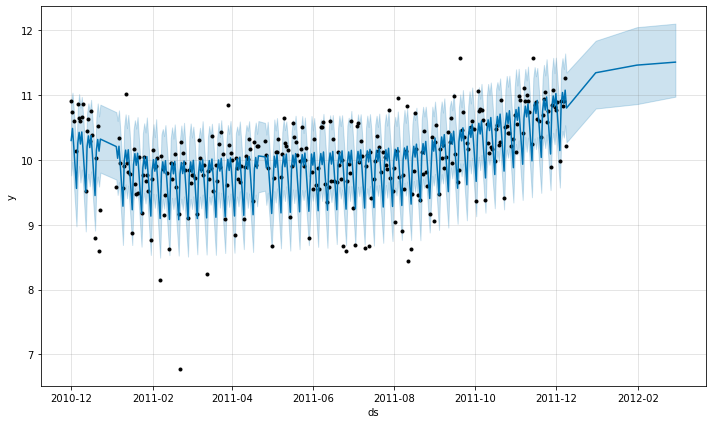

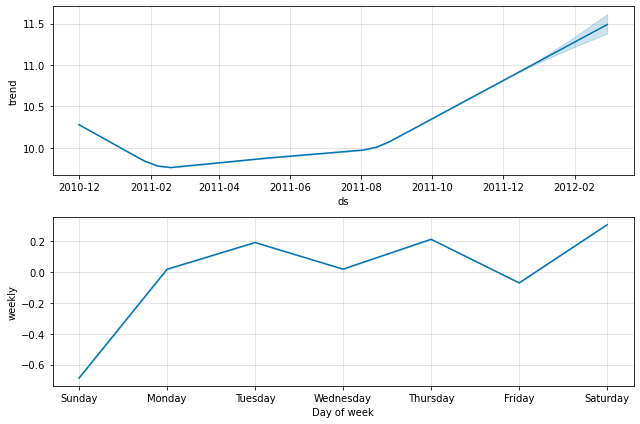

In [152]:
df_cv,df_p,forecast = val_prophet(df_prophet_logp,'additive','270 days' ,'30 days','90 days',0.05)
# transform back using np.exp
df_cv.head()
df_cv.columns[1:5]
for col in df_cv.columns[1:5]:
    df_cv[col]=np.exp(df_cv[col].values)
df_p = performance_metrics(df_cv)
print(f"Average MAPE of first 12 days : {df_p['mape'][:5].mean().round(3)}")
df_p.head(6)

# Weekly prediction

In [153]:
df_prophet

,ds,y
0,2010-12-01,54615.15
1,2010-12-02,46053.93
2,2010-12-03,39985.44
3,2010-12-05,25462.20
4,2010-12-06,52402.84
...,...,...
300,2011-12-05,54715.25
301,2011-12-06,50307.31
302,2011-12-07,55028.58
303,2011-12-08,78437.90


In [154]:
# resample weekly
df_prophet_weekly = df_prophet.set_index('ds')
df_prophet_weekly.index = pd.to_datetime(df_prophet_weekly.index)
df_prophet_weekly=df_prophet_weekly['y'].resample('W-MON').sum()
df_prophet_weekly = df_prophet_weekly.to_frame()
df_prophet_weekly.reset_index(level=0, inplace=True)
df_prophet_weekly.head()

,ds,y
0,2010-12-06,218519.56
1,2010-12-13,226128.39
2,2010-12-20,179512.55
3,2010-12-27,52582.12
4,2011-01-03,0.00


In [155]:
df_prophet_weekly =outliers_to_na(df_prophet_weekly , 2)

C:\Users\andre\AppData\Local\Continuum\anaconda3\envs\fbprophet\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2011-09-13 00:00:00 and 2011-09-13 00:00:00


Average MAPE of first 12 days : 0.367


,horizon,mse,rmse,mae,mape,mdape,coverage
0,6 days,3.136953e+09,56008.507516,56008.507516,0.310579,0.310579,0.0
1,20 days,9.511416e+09,97526.486650,97526.486650,0.439923,0.439923,0.0
2,27 days,1.209301e+10,109968.231217,109968.231217,0.469849,0.469849,0.0
3,34 days,1.519047e+09,38974.955784,38974.955784,0.239147,0.239147,1.0
4,41 days,5.581644e+09,74710.400351,74710.400351,0.376131,0.376131,0.0
5,48 days,6.796584e+09,82441.394917,82441.394917,0.399662,0.399662,0.0


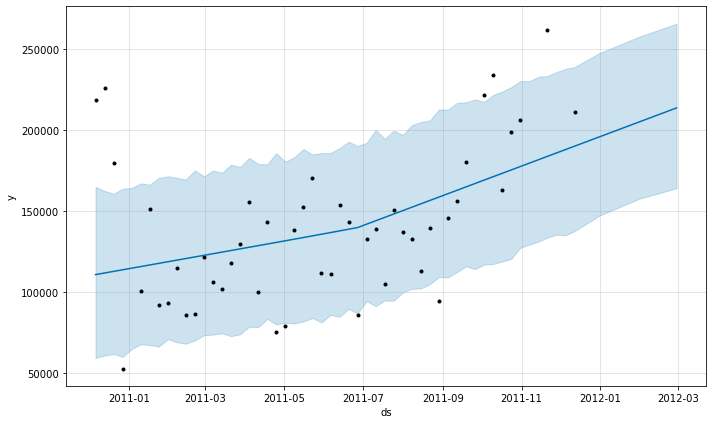

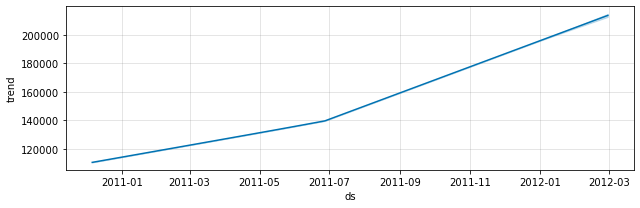

In [156]:
df_cv,df_p,forecast = val_prophet(df_prophet_weekly,'additive','270 days' ,'30 days','90 days',0.1)
print(f"Average MAPE of first 12 days : {df_p['mape'][:5].mean().round(3)}")
df_p.head(6)